<a href="https://colab.research.google.com/github/odus05/Image_Retrieval/blob/master/%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%981_Transfer_Learning(cats_and_dogs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam
from keras import backend as K

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [36]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
### 1. Data Load

In [0]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_cat_dir = '/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs/Cat'
original_dataset_dog_dir = '/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs/Dog'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = '/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
try:
  fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
  for fname in fnames:
      src = os.path.join(original_dataset_cat_dir, fname)
      dst = os.path.join(train_cats_dir, fname)
      shutil.copyfile(src, dst)

  # 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
  fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
  for fname in fnames:
      src = os.path.join(original_dataset_cat_dir, fname)
      dst = os.path.join(validation_cats_dir, fname)
      shutil.copyfile(src, dst)
      
  # 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
  fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
  for fname in fnames:
      src = os.path.join(original_dataset_cat_dir, fname)
      dst = os.path.join(test_cats_dir, fname)
      shutil.copyfile(src, dst)
      
  # 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
  fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
  for fname in fnames:
      src = os.path.join(original_dataset_dog_dir, fname)
      dst = os.path.join(train_dogs_dir, fname)
      shutil.copyfile(src, dst)
      
  # 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
  fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
  for fname in fnames:
      src = os.path.join(original_dataset_dog_dir, fname)
      dst = os.path.join(validation_dogs_dir, fname)
      shutil.copyfile(src, dst)
      
  # 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
  fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
  for fname in fnames:
      src = os.path.join(original_dataset_dog_dir, fname)
      dst = os.path.join(test_dogs_dir, fname)
      shutil.copyfile(src, dst)
except Exception as e:
  print(e)

In [44]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


In [51]:
images = []
for root, _, files in os.walk(train_dir):
    for fname in files[:3]:
        fname = os.path.join(root, fname)
        img = cv2.imread(fname, cv2.IMREAD_COLOR)
        img = np.asarray(img, dtype='float32') / 255
        print('fname: {} | img.shape: {}'.format(fname, img.shape))
        img = cv2.resize(img, (150, 150))
        images.append(img)

fname: /content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/train/cats/cat.0.jpg | img.shape: (375, 500, 3)
fname: /content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/train/cats/cat.1.jpg | img.shape: (281, 300, 3)
fname: /content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/train/cats/cat.2.jpg | img.shape: (397, 312, 3)
fname: /content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/train/dogs/dog.0.jpg | img.shape: (375, 500, 3)
fname: /content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/train/dogs/dog.1.jpg | img.shape: (500, 327, 3)
fname: /content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/train/dogs/dog.2.jpg | img.shape: (199, 188, 3)


In [55]:
K.clear_session()

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=adam(lr=1e-4),
              metrics=['acc'])

model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
________________________

In [63]:
%%time
# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 1999 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 74.6 ms, sys: 1.93 ms, total: 76.6 ms
Wall time: 211 ms


In [64]:
data_batch, labels_batch = next(train_generator)
print('배치 데이터 크기:', data_batch.shape)
print('배치 레이블 크기:', labels_batch.shape)

배치 데이터 크기: (32, 150, 150, 3)
배치 레이블 크기: (32,)


In [65]:
# history = model.fit_generator(
#       train_generator,
#       steps_per_epoch=100,  # 3,200개의 샘플을 처리할 때까지, 100개의 배치를 뽑는다.
#       epochs=100,
#       validation_data=validation_generator,
#       validation_steps=50)
model.save('/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/cats_and_dogs_small_1.h5')

Epoch 1/100
100/100 [==============================] - 41s 415ms/step - loss: 0.6770 - acc: 0.5503 - val_loss: 0.6535 - val_acc: 0.6079
Epoch 2/100
100/100 [==============================] - 37s 368ms/step - loss: 0.6695 - acc: 0.5818 - val_loss: 0.6500 - val_acc: 0.6082
Epoch 3/100
100/100 [==============================] - 36s 365ms/step - loss: 0.6514 - acc: 0.6160 - val_loss: 0.6675 - val_acc: 0.5749
Epoch 4/100
100/100 [==============================] - 37s 367ms/step - loss: 0.6361 - acc: 0.6345 - val_loss: 0.6002 - val_acc: 0.6791
Epoch 5/100
100/100 [==============================] - 36s 365ms/step - loss: 0.6110 - acc: 0.6606 - val_loss: 0.5816 - val_acc: 0.6669
Epoch 6/100
100/100 [==============================] - 40s 400ms/step - loss: 0.5978 - acc: 0.6723 - val_loss: 0.5683 - val_acc: 0.7068
Epoch 7/100
100/100 [==============================] - 37s 374ms/step - loss: 0.5841 - acc: 0.6982 - val_loss: 0.5835 - val_acc: 0.7049
Epoch 8/100
100/100 [===========================

OSError: ignored

In [0]:
def show_history():
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

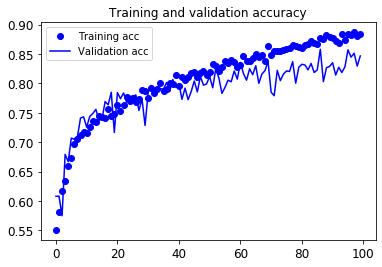

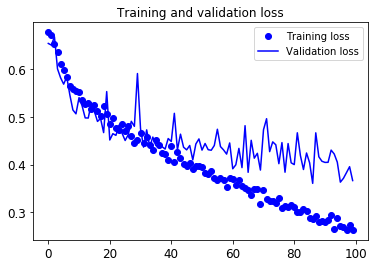

In [79]:
show_history()

데이터가 적기 때문에 컨브넷을 처음부터 훈련해서 더 높은 정확도를 달성하기는 어렵습니다. 이런 상황에서 정확도를 높이기 위한 다음 단계는 사전 훈련된 모델을 사용하는 것입니다.

In [0]:
### 특성 추출(Feature Extraction) -> Transfer Learning

In [80]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [0]:
### 1) 데이터 증식을 사용하지 않는 빠른 특성추출
### - conv_base에 데이터를 주입하고 출력을 저장하고 이를 새로운 모델의 입력에 사용합니다.

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='binary')
    
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        
        if (i+1) * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 
            # 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    
    return features, labels

In [85]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [86]:
print('train_features      : {}, train_labels      : {}'.format(train_features.shape, train_labels.shape))
print('validation_features : {}, validation_labels : {}'.format(validation_features.shape, validation_labels.shape))
print('test_features       : {}, test_labels : {}'.format(test_features.shape, test_labels.shape))

train_features      : (2000, 4, 4, 512), train_labels      : (2000,)
validation_features : (1000, 4, 4, 512), validation_labels : (1000,)
test_features       : (1000, 4, 4, 512), test_labels : (1000,)


In [0]:
train_features = np.reshape(train_features, (-1, 4*4*512))
validation_features = validation_features.reshape([-1, 4*4*512])
test_features = np.reshape(test_features, (-1, 4*4*512))

In [88]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 689us/step - loss: 0.6621 - acc: 0.6145 - val_loss: 0.4666 - val_acc: 0.8260
Epoch 2/30
2000/2000 [==============================] - 1s 433us/step - loss: 0.4558 - acc: 0.7965 - val_loss: 0.3806 - val_acc: 0.8550
Epoch 3/30
2000/2000 [==============================] - 1s 452us/step - loss: 0.3734 - acc: 0.8365 - val_loss: 0.3338 - val_acc: 0.8720
Epoch 4/30
2000/2000 [==============================] - 1s 440us/step - loss: 0.3257 - acc: 0.8690 - val_loss: 0.3093 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 1s 436us/step - loss: 0.2923 - acc: 0.8865 - val_loss: 0.2924 - val_acc: 0.8850
Epoch 6/30
2000/2000 [==============================] - 1s 443us/step - loss: 0.2680 - acc: 0.8980 - val_loss: 0.2853 - val_acc: 0.8780
Epoch 7/30
2000/2000 [==============================] - 1s 436us/step - loss: 0.2552 - acc: 0.9020 - val_loss: 0.2698 - val_acc: 0.8880


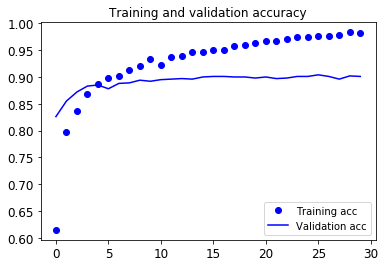

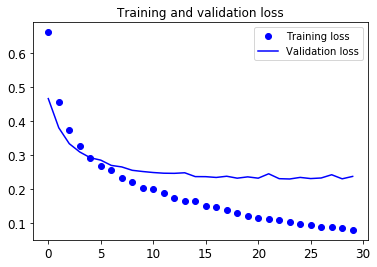

In [90]:
model.compile(optimizer=adam(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data = (validation_features, validation_labels))
model.save('/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/cats_and_dogs_small_2.h5')
show_history()

약 90%의 검증 정확도에 도달했습니다. 이전 절에서 처음부터 훈련시킨 작은 모델에서 얻은 것보다 훨씬 좋습니다. 하지만 이 그래프는 많은 비율로 드롭아웃을 사용했음에도 불구하고 훈련이 시작하면서 거의 바로 과대적합되고 있다는 것을 보여줍니다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문입니다.

In [0]:
### 2) 데이터 증식을 사용한 특성 추출
### - conv_base 모델을 확장하고 입력데이터를 사용해 End-to-End로 실행!!

In [91]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [92]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

# VGG16 Weight Freezing
conv_base.trainable = False

print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30
conv_base를 동결한 후 훈련되는 가중치의 수: 4


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 31s 307ms/step - loss: 0.5443 - acc: 0.7405 - val_loss: 0.4012 - val_acc: 0.8570
Epoch 2/30
100/100 [==============================] - 28s 277ms/step - loss: 0.4034 - acc: 0.8360 - val_loss: 0.3285 - val_acc: 0.8710
Epoch 3/30
100/100 [==============================] - 27s 275ms/step - loss: 0.3567 - acc: 0.8585 - val_loss: 0.2905 - val_acc: 0.8970
Epoch 4/30
100/100 [==============================] - 28s 279ms/step - loss: 0.3211 - acc: 0.8680 - val_loss: 0.3113 - val_acc: 0.8540
Epoch 5/30
100/100 [==============================] - 28s 281ms/step - loss: 0.3022 - acc: 0.8785 - val_loss: 0.2627 - val_acc: 0.8980
Epoch 6/30
100/100 [==============================] - 27s 275ms/step - loss: 0.2788 - acc: 0.8930 - val_loss: 0.2537 - val_acc: 0.9070
Epoch 7/30
100/100 [==============================] - 28s 276ms/step - loss: 0.2703 - acc: 0.8870 - val_lo

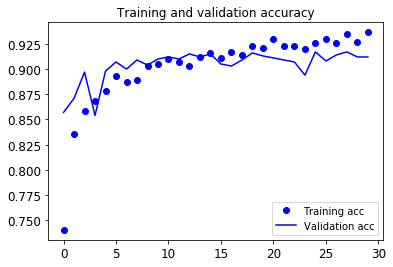

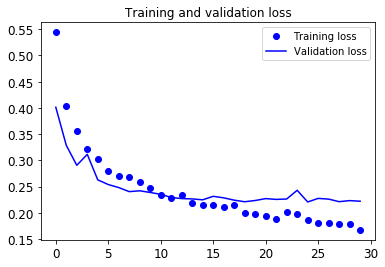

In [93]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=adam(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)
model.save('/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/cats_and_dogs_small_3.h5')
show_history()

검증 정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었습니다.

In [0]:
### 미세 조정(Fine-tuning)
### - 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련 하는 것입니다.

### 미세 조정 방법 ###
###1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.
###2. 기반 네트워크를 동결합니다.
###3. 새로 추가한 네트워크를 훈련합니다.
###4. 기반 네트워크에서 일부 층의 동결을 해제합니다.
###5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

In [0]:
### Unfreezing
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 32s 318ms/step - loss: 0.1721 - acc: 0.9390 - val_loss: 0.1969 - val_acc: 0.9250
Epoch 2/100
100/100 [==============================] - 29s 289ms/step - loss: 0.1475 - acc: 0.938

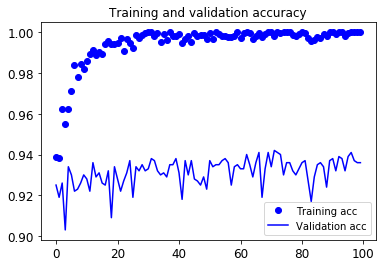

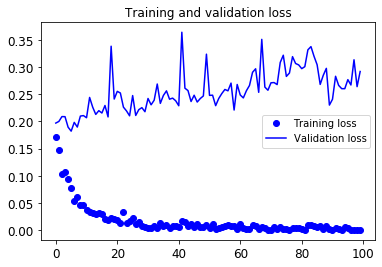

In [103]:
### 학습률을 낮추는 이유는 미세 조정하는 세 개의 층에서 학습된 표현을 조금씩 수정하기 위해서입니다. 변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있습니다.
model.compile(loss='binary_crossentropy',
              optimizer=adam(lr=1e-5),
              metrics=['acc'])
model.summary()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data = validation_generator,
    validation_steps=50)
model.save('/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/cats_and_dogs_small_4.h5')
show_history()

In [0]:
### 그래프가 불규칙하게 보이기 때문에 지수 이동 평균으로 정확도와 손실값을 부드럽게 표현합니다.

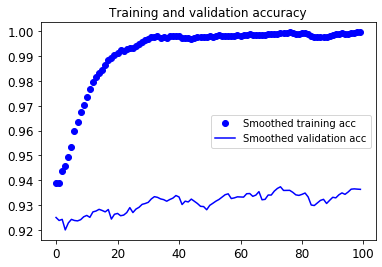

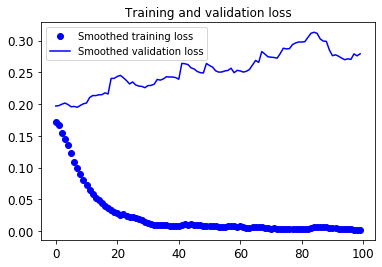

In [109]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [110]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)


Found 1000 images belonging to 2 classes.
test acc: 0.9379999959468841


<정리>
컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델입니다. 아주 작은 데이터셋에서도 처음부터 훈련해서 괜찮은 성능을 낼 수 있습니다.
작은 데이터셋에서는 과대적합이 큰 문제입니다. 데이터 증식은 이미지 데이터를 다룰 때 과대적합을 막을 수 있는 강력한 방법입니다.
특성 추출 방식으로 새로운 데이터셋에 기존의 컨브넷을 쉽게 재사용할 수 있습니다. 작은 이미지 데이터셋으로 작업할 때 효과적인 기법입니다.
특성 추출을 보완하기 위해 미세 조정을 사용할 수 있습니다. 미세 조정은 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응시킵니다. 이 기법은 조금 더 성능을 끌어올립니다.

In [0]:
### 컨브넷 학습 시각화 ###
###  컨브넷의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화하기 아주 좋습니다.
### 1) 컨브넷 중간 층의 출력(중간 층에 있는 활성화)을 시각화하기 : 연속된 컨브넷층이 입력을 어떻게 변형시키는지 이해하고 개별적인 컨브넷 필터의 의미를 파악하는 데 도움이 됩니다.
### 2) 컨브넷 필터를 시각화하기 : 컨브넷의 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 상세하게 이해하는 데 도움이 됩니다.
### 3) 클래스 활성화에 대한 히트맵을 이미지에 시각화하기 : 이미지의 어느 부분이 주어진 클래스에 속하는 데 기여했는지 이해하고 이미지에서 객체의 위치를 추정하는 데 도움이 됩니다.

In [0]:
### 1) 컨브넷 중간 층의 활성화 시각화하기

In [125]:
model = load_model('/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/cats_and_dogs_small_1.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

img_tensor's shape (before expand_dims) : (150, 150, 3)
img_tensor's shape (after expand_dims) : (1, 150, 150, 3)


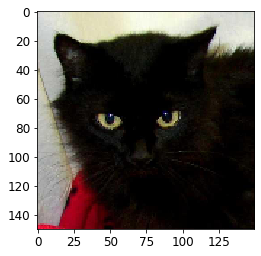

In [126]:
from keras.preprocessing import image

img_path = '/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/test/cats/cat.1500.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
print("img_tensor's shape (before expand_dims) :", img_tensor.shape)

img_tensor = np.expand_dims(img_tensor, axis=0)
print("img_tensor's shape (after expand_dims) :", img_tensor.shape)

# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용합니다
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [128]:
# 상위 8개의 층 출력을 추출  (Flatten 전까지)
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듦
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()
# 이 모델은 하나의 입력(이미지)과 층의 활성화마다 총 8개의 출력을 가집니다.
# 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환한다.
activations = activation_model.predict(img_tensor)
print(len(activations))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0   

8

In [129]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


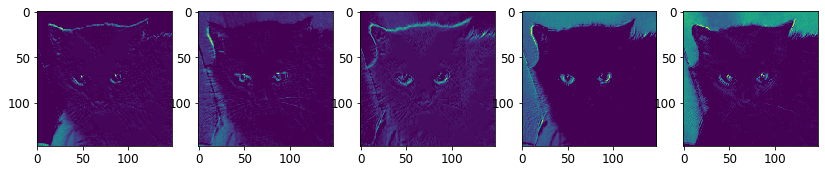

In [131]:
### 32개의 채널을 가진 148 × 148 크기의 특성 맵입니다. 원본 모델의 첫 번째 층의 활성화 중에서 1 ~ 5 번째 채널을 그려 보겠습니다:
fig, axes = plt.subplots(1, 5, figsize=(14,6))
pl_images = [
             first_layer_activation[0,:,:,0],
             first_layer_activation[0,:,:,1],
             first_layer_activation[0,:,:,2],
             first_layer_activation[0,:,:,3],
             first_layer_activation[0,:,:,4]
]
for i, image in enumerate(pl_images):
  axes[i].imshow(image, cmap='viridis')

In [0]:
### 클래스 활성화의 히트맵 시각화 하기!! -> 클래스 활성화 맵(CAM, Class Activation Map) 시각화
### 1. 이미지의 어느 부분이 컨브넷의 최종 분류 결정에 기여하는지 이해하는 데 유용합니다.
### 2. 분류에 실수가 있는 경우 컨브넷의 결정 과정을 디버깅하는 데 도움이 됩니다.
### 3. 또한 이미지에 특정 물체가 있는 위치를 파악하는 데 사용할 수도 있습니다.

In [0]:
### Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
### 1) 입력 이미지가 주어지면 합성곱 층에 있는 특성 맵의 출력을 추출합니다.
### 2) 그 다음 특성 맵의 모든 채널의 출력에 채널에 대한 클래스의 그래디언트 평균을 곱합니다.
### -> '입력 이미지가 각 채널을 활성화하는 정도’에 대한 공간적인 맵을 '클래스에 대한 각 채널의 중요도’로 가중치를 부여하여 '입력 이미지가 클래스를 활성화하는 정도’에 대한 공간적인 맵을 만드는 것입니다.

In [132]:
# 이전 모든 예제에서는 최상단의 완전 연결 분류기를 제외했지만 여기서는 포함합니다
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 16s 0us/step


이 이미지를 VGG16 모델이 인식할 수 있도록 변환해보죠. 이 모델은 224 × 224 크기의 이미지에서 훈련되었고 keras.applications.vgg16.preprocess_input 함수에 있는 몇 가지 규칙에 따라 전처리 되었습니다. 그러므로 이 이미지를 로드해서 224 × 224 크기로 변경하고 넘파이 float32 텐서로 바꾼 다음 이 전처리 함수를 적용해야 합니다.

In [135]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
# 224 x 224 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환된다.
img = image.load_img(img_path, target_size=(224, 224))

# (224, 224, 3) 형태의 NumPy float32 배열
x = image.img_to_array(img)

# 차원을 추가하여 (1, 224, 224, 3) 형태의 배치로 배열을 변환
x = np.expand_dims(x, axis=0)

# 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0]))

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02123394', 'Persian_cat', 0.4020814), ('n02124075', 'Egyptian_cat', 0.110469826), ('n02123045', 'tabby', 0.081295006)]
283


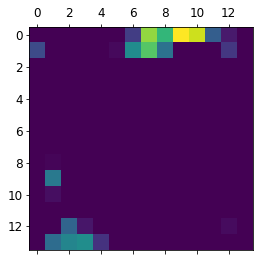

In [136]:
# 예측 벡터의 '고양이' 항목
cat_output = model.output[:, 386]

# VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
grads = K.gradients(cat_output, last_conv_layer.output)[0]

# 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 두 마리 고양이가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate([x])

# "고양이" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

# 시각화를 위해 히트맵을 0과 1 사이로 정규화하겠습니다. 
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()



In [140]:
# cv2 모듈을 사용해 원본 이미지를 로드합니다
img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경합니다
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환합니다
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환합니다
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도입니다
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장합니다
cv2.imwrite('/content/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/cat_cam02.jpg', superimposed_img)

True